In [1]:
from rdkit import Chem
import numpy as np
import pandas as pd
import requests
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

## Load reaxys data

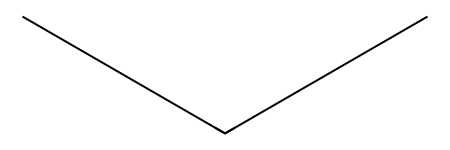

In [4]:
suppl = Chem.rdmolfiles.SDMolSupplier('../data/reaxys_dataset_full.sdf')
mols = [mol for mol in suppl if mol]
display(mols[1])

### Filter data for molecules where the boiling point was measured at 760 torr and does not contain isotopes

In [5]:
mols_filtered = []
for mol in mols:
    try:
        mol.GetProp('BP.BP')
        mol.GetProp('BP.P')
        mols_filtered.append(mol)
    except:
        pass

In [6]:
mols_filtered = [mol for mol in mols_filtered if mol.GetProp('BP.P') == '760']

In [7]:
mols_filtered = [mol for mol in mols_filtered if 'isotope' not in mol.GetProp('IDE.STYPE')]

In [8]:
len(mols_filtered)

630

In [9]:
def is_alkane(mol, print_reason = False):
    if mol.HasSubstructMatch(Chem.MolFromSmarts('[!#6;!#1]')):
        if print_reason: print("Atom that is not C or H")
        return False
    elif mol.HasSubstructMatch(Chem.MolFromSmarts('*!-*')):
        if print_reason: print("Bond, that is not single")
        return False
    elif mol.HasSubstructMatch(Chem.MolFromSmarts('[*-]')):
        if print_reason: print("Negative charge")
        return False
    elif mol.HasSubstructMatch(Chem.MolFromSmarts('[*+]')):
        if print_reason: print("Positive charge")
        return False
    elif mol.HasSubstructMatch(Chem.MolFromSmarts('[R]')):
        if print_reason: print("Cycle")
        return False
    elif mol.HasSubstructMatch(Chem.MolFromSmarts('[13C,14C,8C,9C,10C,11C,15C,16C,17C,18C,19C,20C,21C,22C]')):
        if print_reason: print("Carbon isotope")
        return False
    elif mol.HasSubstructMatch(Chem.MolFromSmarts('[2H]')) or mol.HasSubstructMatch(Chem.MolFromSmarts('[3H]')):
        if print_reason: print("Hydrogen isotope")
        return False
    elif mol.HasSubstructMatch(Chem.MolFromSmarts('[C!X4]')):
        if print_reason: print("Radical")
        return False
    else: return True

In [10]:
for mol in mols_filtered:
    if not is_alkane(mol):
        display(mol)

### Calculate the average boiling point for each molecule (by InChIKey)

In [11]:
data = []
for mol in mols_filtered:
    if mol is not None:
        name = mol.GetProp('IDE.CN')
        bp = mol.GetProp('BP.BP')
        inchi = mol.GetProp('IDE.INCHI')
        
        try:
            bp_value = float(bp) 
            data.append((bp_value, inchi))
        except ValueError:
            pass

df = pd.DataFrame(data, columns=['boiling_point', 'InChIKey'])

df_reaxys = df.groupby('InChIKey', as_index=False)['boiling_point'].mean()

print(df_reaxys.head())

                      InChIKey  boiling_point
0  ABYGSZMCWVXFCQ-UHFFFAOYSA-N       162.0000
1  ACYHSTUWOQNWCX-UHFFFAOYSA-N       158.0000
2  AEXMKKGTQYQZCS-UHFFFAOYSA-N        86.0560
3  AFABGHUZZDYHJO-UHFFFAOYSA-N        60.2275
4  AFELDWXNIFIYOC-UHFFFAOYSA-N       236.0000


### Load CRC Handbook data

In [12]:
df_crc = pd.read_csv('../data/alkanes_with_zagreb.csv', sep=';')
df_crc.head()

,name,boiling_point,SMILES,IUPAC_name,CID,molecular_formula,M1,M2,InChIKey,num_atoms
0,Butane,-0.5,CCCC,butane,7843,C4H10,10,8,IJDNQMDRQITEOD-UHFFFAOYSA-N,4
1,Dodecane,216.3,CCCCCCCCCCCC,dodecane,8182,C12H26,42,40,SNRUBQQJIBEYMU-UHFFFAOYSA-N,12
2,Propane,-42.1,CCC,propane,6334,C3H8,6,4,ATUOYWHBWRKTHZ-UHFFFAOYSA-N,3
3,Ethane,-88.6,CC,ethane,6324,C2H6,2,1,OTMSDBZUPAUEDD-UHFFFAOYSA-N,2
4,5-Butyldocosane,244.0,CCCCCCCCCCCCCCCCCC(CCCC)CCCC,5-butyldocosane,143267,C26H54,100,100,CSRNPDQIQWQJCM-UHFFFAOYSA-N,26


In [13]:
for s in df_crc.SMILES:
    if not is_alkane(Chem.MolFromSmiles(s)): display(s)

### Comparison of CRC and Reaxys

#### Size

In [14]:
df_common = df_reaxys.merge(df_crc, on='InChIKey', suffixes=('_reaxys', '_crc'))

In [15]:
df_comparison = df_common[['name', 'boiling_point_reaxys', 'boiling_point_crc']].copy()
df_comparison['diff'] = df_comparison['boiling_point_crc'] - df_comparison['boiling_point_reaxys']

In [16]:
print('Mean difference: ', df_comparison['diff'].mean())
display(df_comparison.head(3))

Mean difference:  -0.19744040094039972


,name,boiling_point_reaxys,boiling_point_crc,diff
0,4-Propylheptane,162.0000,167.00,5.0000
1,"3,3-Dimethylpentane",86.0560,86.00,-0.0560
2,2-Methylpentane,60.2275,60.21,-0.0175


In [17]:
print('CRC size: ', df_crc.shape[0])
print('Reaxys size: ', df_reaxys.shape[0])
print('Number of molecules in common: ', df_common.shape[0])

CRC size:  135
Reaxys size:  298
Number of molecules in common:  111


#### Molecular weight

Calculate molecular weights for both datasets

In [18]:
df_crc['Mol'] = df_crc['SMILES'].apply(Chem.MolFromSmiles)
df_crc['MW'] = df_crc['Mol'].apply(lambda mol: Descriptors.MolWt(mol))

In [19]:
def get_pubchem_data(inchikey):
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchikey/{inchikey}/property/CanonicalSMILES,IUPACName,MolecularFormula/JSON"
    response = requests.get(url).json()
    data = response.get("PropertyTable", {}).get("Properties", [{}])[0]
    return data.get("CanonicalSMILES"), data.get("IUPACName"), data.get("MolecularFormula")
    

In [20]:
df_reaxys

,InChIKey,boiling_point
0,ABYGSZMCWVXFCQ-UHFFFAOYSA-N,162.0000
1,ACYHSTUWOQNWCX-UHFFFAOYSA-N,158.0000
2,AEXMKKGTQYQZCS-UHFFFAOYSA-N,86.0560
3,AFABGHUZZDYHJO-UHFFFAOYSA-N,60.2275
4,AFELDWXNIFIYOC-UHFFFAOYSA-N,236.0000
...,...,...
293,ZRTXVJYJVBTXHE-UHFFFAOYSA-N,165.0000
294,ZTPLUCDDNLWAIC-UHFFFAOYSA-N,295.5000
295,ZUBZATZOEPUUQF-UHFFFAOYSA-N,142.5160
296,ZYQYQXNPWMWTDD-UHFFFAOYSA-N,240.0000


In [53]:
df_reaxys['Mol'] = df_reaxys['SMILES'].apply(Chem.MolFromSmiles)
df_reaxys['MW'] = df_reaxys['Mol'].apply(lambda mol: Descriptors.MolWt(mol))

In [54]:
df_reaxys.head()

,InChIKey,boiling_point,SMILES,IUPAC_Name,molecular_formula,Mol,MW
0,ABYGSZMCWVXFCQ-UHFFFAOYSA-N,162.0000,CCCC(CCC)CCC,4-propylheptane,C10H22,<rdkit.Chem.rdchem.Mol object at 0x0000028ACE4...,142.286
1,ACYHSTUWOQNWCX-UHFFFAOYSA-N,158.0000,CCCCC(C)C(C)(C)C,"2,2,3-trimethylheptane",C10H22,<rdkit.Chem.rdchem.Mol object at 0x0000028ACB4...,142.286
2,AEXMKKGTQYQZCS-UHFFFAOYSA-N,86.0560,CCC(C)(C)CC,"3,3-dimethylpentane",C7H16,<rdkit.Chem.rdchem.Mol object at 0x0000028ACB4...,100.205
3,AFABGHUZZDYHJO-UHFFFAOYSA-N,60.2275,CCCC(C)C,2-methylpentane,C6H14,<rdkit.Chem.rdchem.Mol object at 0x0000028ACB4...,86.178
4,AFELDWXNIFIYOC-UHFFFAOYSA-N,236.0000,CCCCCCCCC(C)CC(C)C,"2,4-dimethyldodecane",C14H30,<rdkit.Chem.rdchem.Mol object at 0x0000028ACB4...,198.394


In [11]:
df_crc.to_csv("crc.csv", sep=";",columns=["name","boiling_point","SMILES","IUPAC_name","CID","molecular_formula","M1","M2","num_atoms","MW", "InChIKey"],index=False)

In [57]:
df_reaxys.to_csv("reaxys.csv", sep=";",columns=["InChIKey","boiling_point","SMILES","IUPAC_Name","molecular_formula","MW"],index=False)

In [23]:
df_crc = pd.read_csv('../data/crc.csv', sep=';')
df_reaxys = pd.read_csv('../data/reaxys.csv', sep=';')

df_crc['Mol'] = df_crc['SMILES'].apply(Chem.MolFromSmiles)
df_reaxys['Mol'] = df_reaxys['SMILES'].apply(Chem.MolFromSmiles)

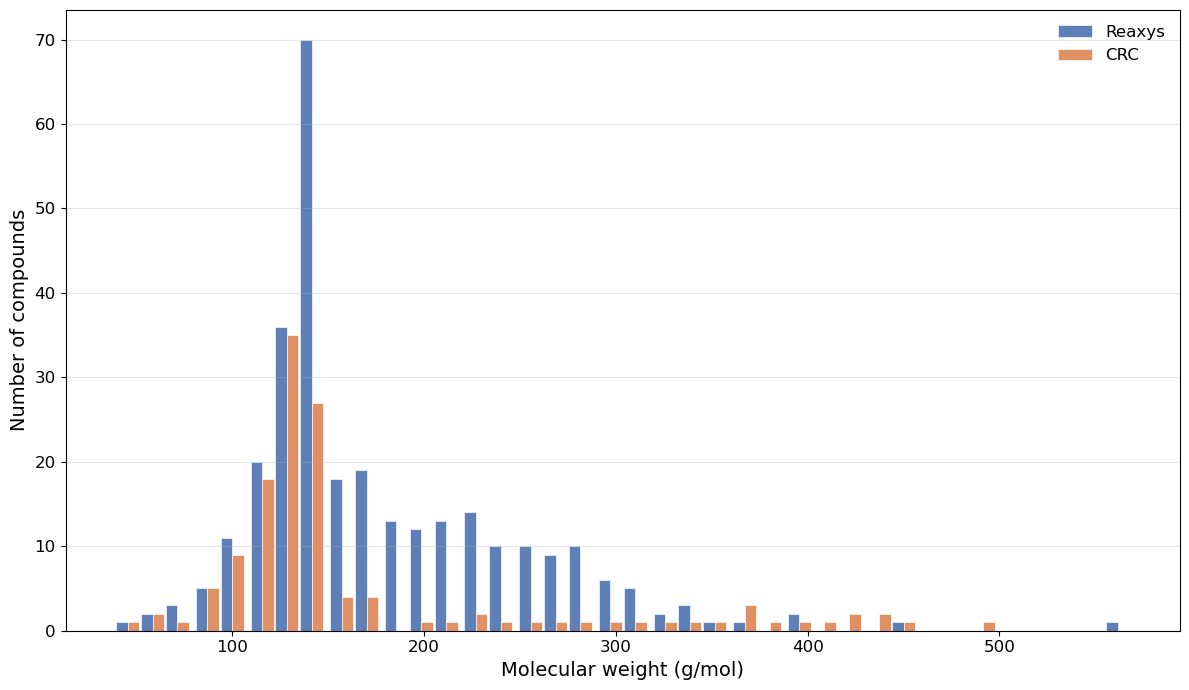

In [44]:
bins = 200
width = 6  # Width of each bar

plt.figure(figsize=(12, 7))

# Histogram data
counts_reaxys, bin_edges = np.histogram(df_reaxys['MW'].dropna(), bins=bins)
counts_crc, _ = np.histogram(df_crc['MW'].dropna(), bins=bin_edges)

# Bar positions
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
x_reaxys = bin_centers - width / 2
x_crc = bin_centers + width / 2

# Plot bars with improved style
plt.bar(x_reaxys, counts_reaxys, width=width, color='#4C72B0', alpha=0.9, label='Reaxys', edgecolor='white', linewidth=0.5)
plt.bar(x_crc, counts_crc, width=width, color='#DD8452', alpha=0.9, label='CRC', edgecolor='white', linewidth=0.5)

# Labels and title
# plt.title('Distribution of molecular weights', fontsize=16, weight='bold')
plt.xlabel('Molecular weight (g/mol)', fontsize=14)
plt.ylabel('Number of compounds', fontsize=14)

# Legend and grid
plt.legend(frameon=False, fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Tight layout for saving/embedding
plt.tight_layout()
plt.savefig("../img/histogram_crc_reaxys_mw.svg", format="svg")
plt.show()

In [55]:
# Extract the InChIKey columns as sets
set_crc = set(df_crc['InChIKey'])
set_reaxys = set(df_reaxys['InChIKey'])

# Common InChIKeys
common = set_crc.intersection(set_reaxys)
num_common = len(common)

# Extra in each dataframe
extra_crc = set_crc - set_reaxys
extra_reaxys = set_reaxys - set_crc

print(f"Common InChIKeys: {num_common}")
print(f"Only in df_crc: {len(extra_crc)}")
print(f"Only in df_reaxys: {len(extra_reaxys)}")


Common InChIKeys: 111
Only in df_crc: 24
Only in df_reaxys: 187


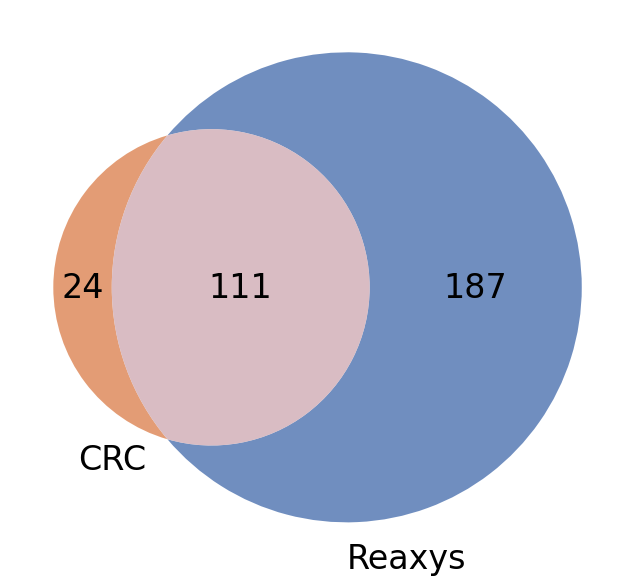

In [27]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Your numbers
common = 111
only_crc = 24
only_reaxys = 187

plt.figure(figsize=(10, 6))

v = venn2(
    subsets=(only_crc, only_reaxys, common),
    set_labels=('CRC', 'Reaxys'),
    set_colors=("#DD8452", "#4C72B0"),
    alpha=0.8,
)

# Style the set labels
for i, text in enumerate(v.set_labels):
    text.set_fontsize(24)
    text.set_fontweight('normal')
    if i == 0:  # Shift the df_crc label (left set)
        x, y = text.get_position()
        text.set_position((x - 0.15, y+0.05))  # shift left by 0.1 units

# Style subset labels (numbers inside)
for text in v.subset_labels:
    if text:
        text.set_fontsize(24)
        text.set_color("black")

# plt.title("InChIKey Overlap Between df_crc and df_reaxys", fontsize=16, weight='bold')
plt.tight_layout()
plt.savefig("../img/venn_crc_reaxys.svg", format="svg")
plt.show()


#### Branching

In [33]:
from rdkit import Chem
import math

def randic_index(mol):
    index = 0.0
    for bond in mol.GetBonds():
        deg1 = bond.GetBeginAtom().GetDegree()
        deg2 = bond.GetEndAtom().GetDegree()
        index += 1.0 / math.sqrt(deg1 * deg2)
    return index

In [34]:
df_crc['RI'] = df_crc['Mol'].apply(randic_index)
df_reaxys['RI'] = df_reaxys['Mol'].apply(randic_index)

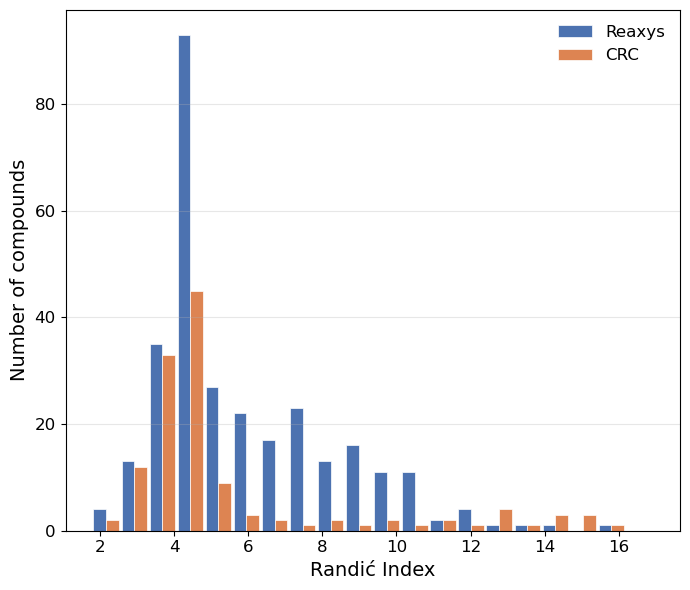

In [40]:
import numpy as np
import matplotlib.pyplot as plt

bins = 20

# Combine data
data_reaxys = df_reaxys['RI'].dropna()
data_crc = df_crc['RI'].dropna()
combined = np.concatenate([data_reaxys, data_crc])

# Calculate percentile bounds to zoom in on central data
lower_bound = np.percentile(combined, 1)
upper_bound = np.percentile(combined, 99)

# Filter data within bounds
filtered_reaxys = data_reaxys[(data_reaxys >= lower_bound) & (data_reaxys <= upper_bound)]
filtered_crc = data_crc[(data_crc >= lower_bound) & (data_crc <= upper_bound)]

# Histogram bins within range
bin_edges = np.linspace(lower_bound, upper_bound, bins + 1)
bin_width = bin_edges[1] - bin_edges[0]

# Histogram counts
counts_reaxys, _ = np.histogram(filtered_reaxys, bins=bin_edges)
counts_crc, _ = np.histogram(filtered_crc, bins=bin_edges)

bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure(figsize=(7, 6))

# Bar width for side-by-side bars
bar_width = bin_width * 0.45

plt.bar(bin_centers - bar_width/2, counts_reaxys, width=bar_width,
    color='#4C72B0', alpha=1, label='Reaxys', edgecolor='white', linewidth=0.5)
plt.bar(bin_centers + bar_width/2, counts_crc, width=bar_width,
    color='#DD8452', alpha=1, label='CRC', edgecolor='white', linewidth=0.5)

plt.xlabel('Randić Index', fontsize=14)
plt.ylabel('Number of compounds', fontsize=14)
plt.legend(frameon=False, fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("../img/randic_index_histogram_2.svg", format="svg")
plt.show()
